# PHYS3070 2025: Straight-ray 2D tomography

<a href="https://colab.research.google.com/github/tsonpham/InvProb/blob/master/Lec4_Tomo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepared by Thanh-Son Pham (thanhson.pham@anu.edu.au), September 2025.

---
## What we do in this notebook:
- Straight-ray tomography as an linear inverse problem.
- Building a tomographic design matrx.
- Zeroth-order Tikhonov regularization

In [1]:
#@title Run to activate retina display

%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10

---
## Problem setup

In [ ]:
#@title Supporting functions for straight-ray tomography

import numpy as np

def compute_ray_segment_length(xsrc, ysrc, xrcv, yrcv, xgrid, ygrid, debug=False):
    ''' 
    Compute segment lengths of a straight ray within crossing grid cells
    Params:
    - xsrc, ysrc: Source coordinates
    - xrcv, yrcv: Receiver coordinates
    - xgrid, ygrid: Grid cell boundaries
    Return:
    - dl_cell: Ray segment lengths in each grid cell
    '''
    ## Determine intersections of the ray to x-grids
    if xsrc != xrcv:  # vertical crosses
        xfrac = (xgrid-xsrc) / (xrcv-xsrc)
        x1 = np.concatenate(([xsrc, xrcv], xgrid[(xfrac>0) & (xfrac<1)]))
        y1 = (yrcv-ysrc) / (xrcv-xsrc) * (x1 - xsrc) + ysrc
        vcrosses = np.column_stack((x1, y1))
    else: 
        vcrosses = None
    ## Determine intersections of the ray to y-grids
    if ysrc != yrcv:  # horizontal ray
        yfrac = (ygrid-ysrc) / (yrcv-ysrc)
        y2 = ygrid[(yfrac>0) & (yfrac<1)]
        x2 = (xrcv-xsrc) / (yrcv-ysrc) * (y2 - ysrc) + xsrc
        hcrosses = np.column_stack((x2, y2))
    else:
        hcrosses = None
    ## Combine all intersections
    if vcrosses is None:
        intersections = hcrosses
    elif hcrosses is None:
        intersections = vcrosses
    else:
        intersections = np.vstack((vcrosses, hcrosses))

    ## Sort intersections point by their distance from the source
    dist_from_src = np.sqrt(np.sum((intersections-[xsrc, ysrc])**2, axis=1))
    sorted_intersections = intersections[np.argsort(dist_from_src)]
    ## Compute midpoints of each segment larger than tol
    segment_midpoints = (sorted_intersections[:-1] + sorted_intersections[1:]) / 2
    dist_from_src = np.sqrt(np.sum((sorted_intersections-[xsrc, ysrc])**2, axis=1))

    ## Assign ray lengths to grid cells
    dl_cell = np.zeros((len(xgrid)-1, len(ygrid)-1))
    ii = np.digitize(segment_midpoints[:, 0], xgrid) - 1
    jj = np.digitize(segment_midpoints[:, 1], ygrid) - 1
    mask = (ii >= 0) & (ii < dl_cell.shape[0]) & (jj >= 0) & (jj < dl_cell.shape[1])
    dl_cell[ii[mask], jj[mask]] = np.diff(dist_from_src)[mask]

    if debug:
        return dl_cell, sorted_intersections
    else:
        return dl_cell.ravel()

def build_design_matrix(src_xy, rcv_xy, xgrid, ygrid):
    ''' 
    Build the design matrix for straight ray paths given source and receiver coordinates
    Params:
    - src_xy: Source coordinates (N, 2)
    - rcv_xy: Receiver coordinates (N, 2)
    - xgrid: X grid boundaries
    - ygrid: Y grid boundaries
    Return: 
    - G: returned design matrix (number of rays, number of cells)
    '''
    G = []
    for src, rcv in zip(src_xy, rcv_xy):
        G.append(compute_ray_segment_length(src[0], src[1], rcv[0], rcv[1], xgrid, ygrid))
    return np.array(G)

def plot_model(v_true, v_inv, src_xy, rcv_xy, xgrid, ygrid):
    import matplotlib.pyplot as plt
    xmin, xmax = xgrid.min(), xgrid.max()
    ymin, ymax = ygrid.min(), ygrid.max()
    xmesh, ymesh = np.meshgrid((xgrid[:-1]+xgrid[1:])/2, (ygrid[:-1]+ygrid[1:])/2, indexing='ij')
    ## Plot problem setup
    fig, ax = plt.subplots(2, 2, figsize=(7, 7))
    for _ in ax.flatten():
        _.set(aspect='equal', xlabel='x', ylabel='y', xlim=(xmin, xmax), ylim=(ymin, ymax))
    ## True input velocity model
    ax[0, 0].pcolormesh(xmesh, ymesh, v_true, shading='auto', cmap='viridis', vmin=v_true.min(), vmax=v_true.max())
    ax[0, 0].set_title('True velocity model')
    ## Ray path coverage
    for y in ygrid:
        ax[0, 1].hlines(y, xmin=xgrid.min(), xmax=xgrid.max(), color='gray', lw=0.5)
    for x in xgrid:
        ax[0, 1].vlines(x, ymin=ygrid.min(), ymax=ygrid.max(), color='gray', lw=0.5)
    for src, rcv in zip(src_xy, rcv_xy):
        ax[0, 1].plot([src[0], rcv[0]], [src[1], rcv[1]], color='r', lw=1, alpha=.2)
    ax[0, 1].set_title('Ray path coverage')
    ## Recovered velocity model
    # ax[1, 0].pcolormesh(xmesh, ymesh, dv_v_inv, shading='auto', cmap='viridis', vmin=dv_v_true.min(), vmax=dv_v_true.max())
    ax[1, 0].pcolormesh(xmesh, ymesh, v_inv, shading='auto', cmap='viridis', vmin=v_true.min(), vmax=v_true.max())
    ax[1, 0].set_title('Recovered velocity model')
    ## Difference model
    # ax[1, 1].pcolormesh(xmesh, ymesh, dv_v_inv - dv_v_true, shading='auto', cmap='gray', vmin=dv_v_true.min(), vmax=dv_v_true.min())
    # ax[1, 1].set_title('Model difference')
    ax[1, 1].axis('off')
    fig.tight_layout()

def calc_curvature(residual_norms, solution_norms, alphas):
    ''' Calculate curvature of the L-curve '''
    log_rn = np.log10(residual_norms)
    log_sn = np.log10(solution_norms)
    d_log_rn = np.gradient(log_rn, alphas)
    d_log_sn = np.gradient(log_sn, alphas)
    dd_log_rn = np.gradient(d_log_rn, alphas)
    dd_log_sn = np.gradient(d_log_sn, alphas)
    curvature = np.abs(d_log_sn * dd_log_rn - d_log_rn * dd_log_sn) / (d_log_rn**2 + d_log_sn**2)**1.5
    return curvature

In this example, we assume seismic wave travel along straight path in 2D surface, regardless of background velocities. Under this assumption, the travel time between two point is $t = \int_{path} \frac{dl}{v}$.

If we discrite a large square region into $n$ equal area blocks, called pixels, of constant, but unnown velocities, $\{v_j; j=1,\ldots, n\}$. The travel time along a straight ray path can be taken as summed of travel times spent in each discrete blocks,

$$
t_i = \sum_{j=1}^n \frac{\delta l_{ij}}{v_j} = \sum_{j=1}^n = \delta l_{ij} s_j.
$$

When set $s_i = 1/v_i$ is the slowness of block $i$-th.

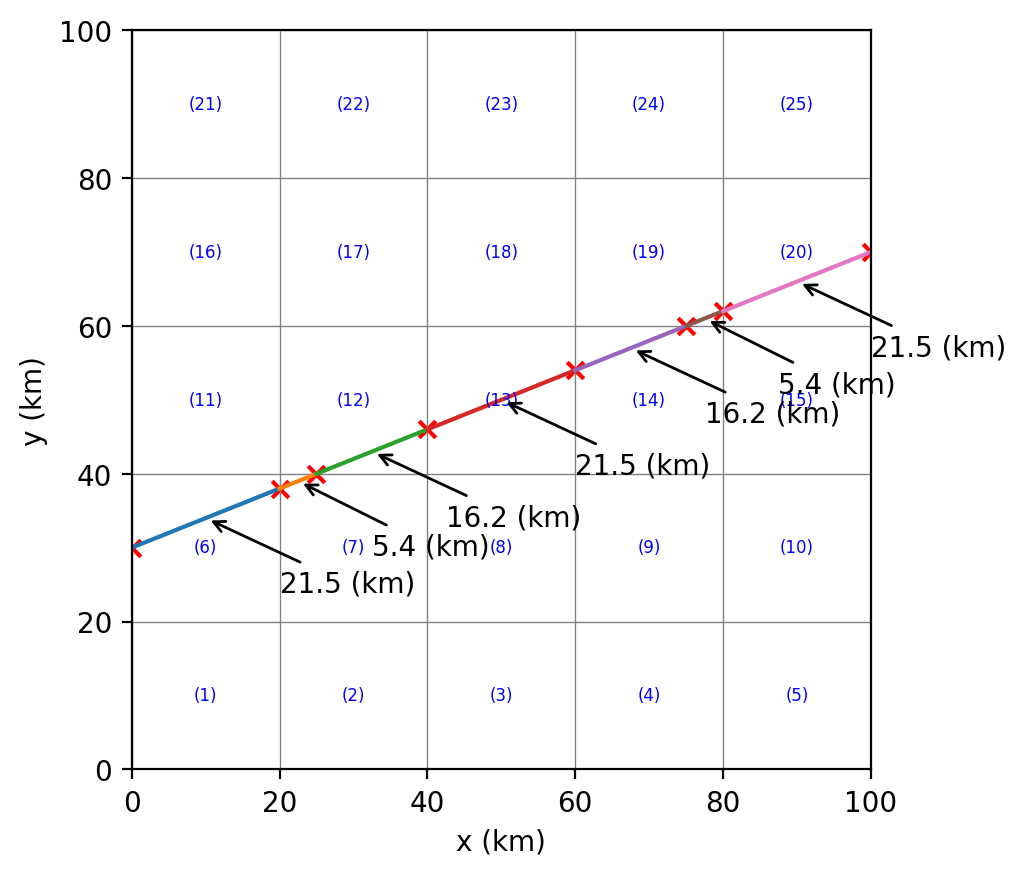

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Computation domain
xmin, xmax = 0, 100
xcenter = (xmin + xmax) / 2
ymin, ymax = 0, 100
ycenter = (ymin + ymax) / 2
## Grid cell definition
xgrid = np.linspace(xmin, xmax, 6)
ygrid = np.linspace(ymin, ymax, 6)
## Coordinate of grid cell centers
xmesh, ymesh = np.meshgrid((xgrid[:-1]+xgrid[1:])/2, (ygrid[:-1]+ygrid[1:])/2, indexing='ij')

dl_cell, sorted_intersections = compute_ray_segment_length(xsrc=xmin, ysrc=30, xrcv=xmax, yrcv=70, xgrid=xgrid, ygrid=ygrid, debug=True)

fig, ax = plt.subplots()

for x in xgrid:
    ax.vlines(x, ymin=ygrid.min(), ymax=ygrid.max(), color='gray', lw=0.5)
for y in ygrid:
    ax.hlines(y, xmin=xgrid.min(), xmax=xgrid.max(), color='gray', lw=0.5)

for i in range(xgrid.size-1):
    for j in range(ygrid.size-1):
        ax.text(xmesh[j, i], ymesh[j, i], f'({i*(xgrid.size-1) + j + 1})', color='blue', ha='center', va='center', fontsize=6)

for i in range(len(sorted_intersections)-1):
    seg = np.array([sorted_intersections[i], sorted_intersections[i+1]])
    ax.plot(seg[:, 0], seg[:, 1])
    x, y = (seg[0, 0]+seg[1, 0])/2, (seg[0, 1]+seg[1, 1])/2
    ax.annotate(f'{np.linalg.norm(seg[1]-seg[0]):.1f} (km)', xy=(x, y), xytext=(x+10, y-10), 
                arrowprops=dict(arrowstyle='->'))
ax.scatter(sorted_intersections[:, 0], sorted_intersections[:, 1], marker='x', color='r')

ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), xlabel='x (km)', ylabel='y (km)', aspect='equal')

plt.show()

If there are $m$ ray paths, corresponding to measured travel times, $\{t_i, i=1, \ldots, m\}$, the forward problem can be written in a linear forward form,
$$
\mathbf{d} = \mathbf{G} \mathbf{m}.
$$

In the example below, there are 20 ray paths, thus the design matrix $\mathbf{G}$ has dimensions $20\times 25$, which is not invertible and ill-conditions. 

We seek the 0-th Tikhonov regularised solution as such,
$$
\min_m ||\mathbf{G}\mathbf{m} - \mathbf{d}||_2^2 + \alpha ||\mathbf{m}||_2^2,
$$
where $\alpha>0$ is a regularization parameter.

The $L$-curve, presenting the solution norm vs the residual norm, is often used to determine the optimal regularisation parameter, $\alpha$.

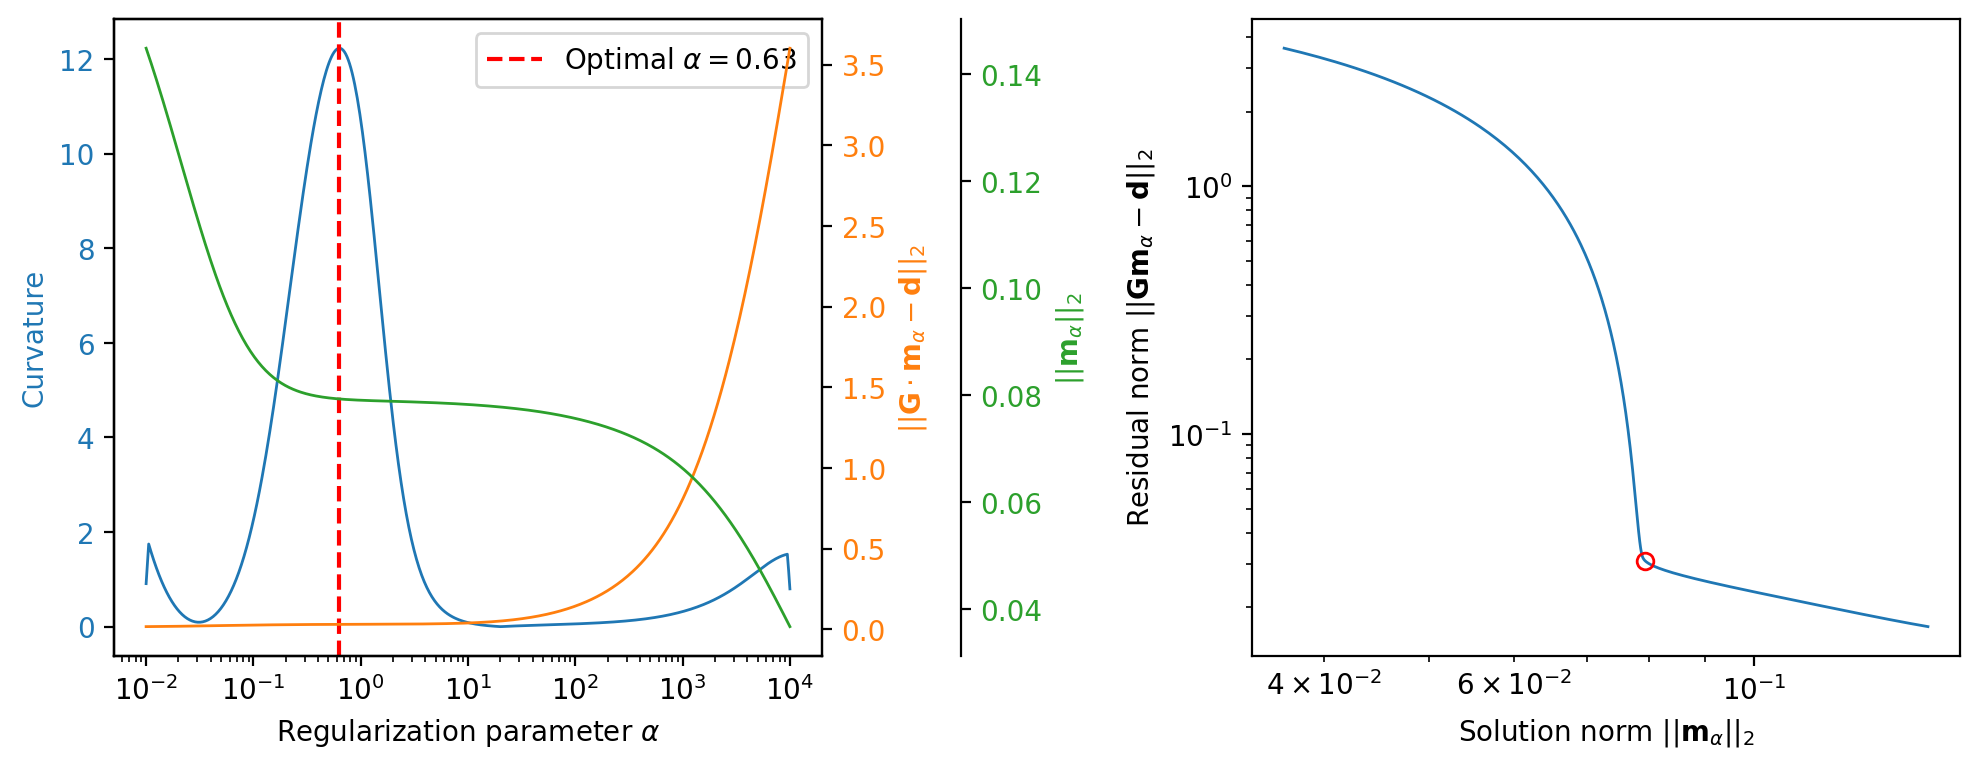

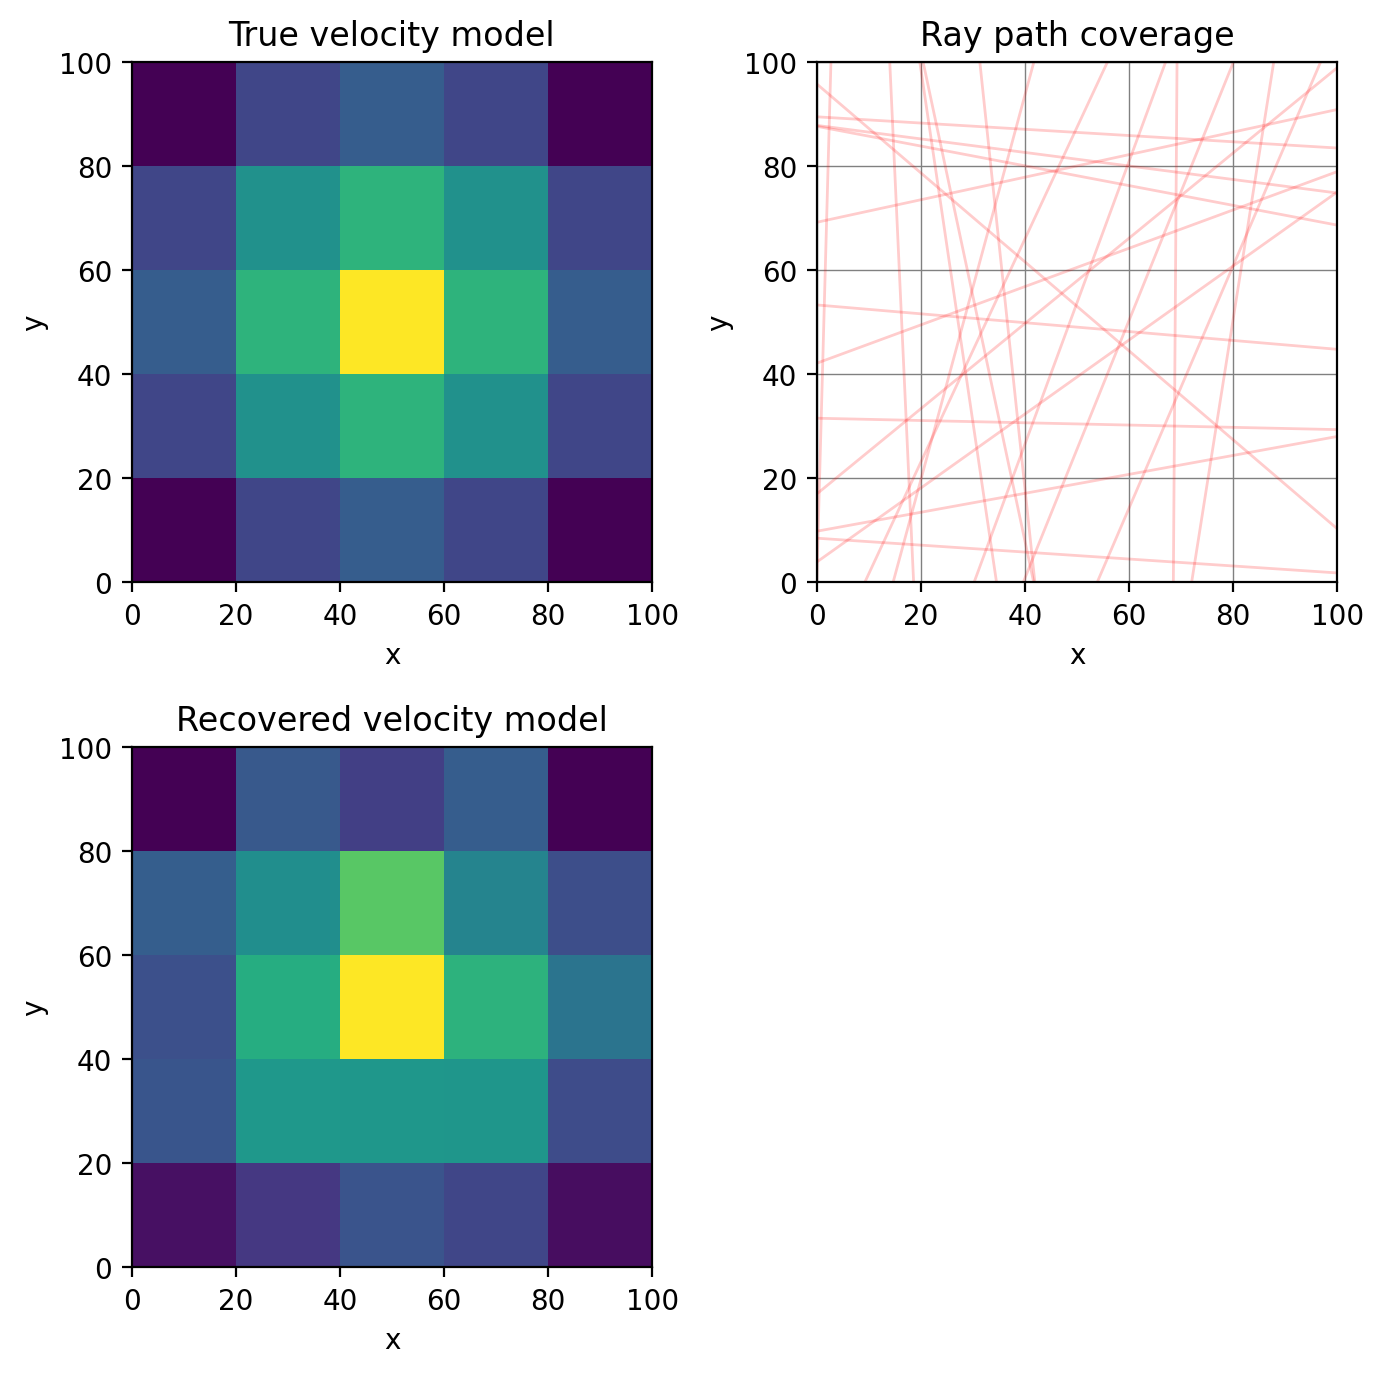

In [4]:
## Random ray path crossing
np.random.seed(1)
nrays = 12

src_xy = np.column_stack((np.random.uniform(xmin, xmax, nrays), np.full(nrays, ymin)))
rcv_xy = np.column_stack((np.random.uniform(xmin, xmax, nrays), np.full(nrays, ymax)))
src_xy = np.vstack((src_xy, np.column_stack((np.full(nrays, xmin), np.random.uniform(ymin, ymax, nrays)))))
rcv_xy = np.vstack((rcv_xy, np.column_stack((np.full(nrays, xmax), np.random.uniform(ymin, ymax, nrays)))))

## Create design matrix of distance to segment
G = build_design_matrix(src_xy, rcv_xy, xgrid, ygrid) 
U, s, Vh = np.linalg.svd(G, full_matrices=False)

## True velocity model 
v0 = 3.5 # background velocity
d = np.sqrt((xmesh - xcenter)**2 + (ymesh - ycenter)**2)
v_true = v0 + (d.max() - d) / d.max() * .5

## Simulate travel residual travel times
m_true = 1 / v_true.ravel() - 1 / v0 # model perturbation in slowness
dt = G @ m_true + np.random.normal(0, 0.05, G.shape[0]) # residual travel times with noise

## Tikhonov matrix H
H = np.eye(G.shape[1]) # Identity matrix for zeroth-order Tikhonov
alphas = np.logspace(-2, 4, 501)
m_alphas = []
solution_norms = []
residual_norms = []
for a in alphas: 
    m = Vh.T @ ( (s / (s**2 + a)) * (U.T @ dt) )  # SVD solution
    m_alphas.append(m)
    solution_norms.append(np.linalg.norm(H @ m))
    residual_norms.append(np.linalg.norm(G @ m - dt))
curvature = calc_curvature(residual_norms, solution_norms, alphas)
alpha_opt_idx = np.argmax(curvature)
alpha_opt = alphas[alpha_opt_idx]
v_alpha = 1 / (m_alphas[alpha_opt_idx].reshape(v_true.shape) + 1/v0)

## Plot L-curve and curvature
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].semilogx(alphas, curvature, lw=1, c='C0')
ax[0].set_ylabel('Curvature', color='C0')
ax[0].axvline(alpha_opt, color='r', ls='--', label=f'Optimal $\\alpha={alpha_opt:.2f}$')
ax[0].tick_params(axis='y', labelcolor='C0')
ax1 = ax[0].twinx()
ax1.semilogx(alphas, residual_norms, lw=1, c='C1')
ax1.set_ylabel('$||\\mathbf{G}\\cdot\\mathbf{m}_\\alpha-\\mathbf{d}||_2$', color='C1')
ax1.tick_params(axis='y', labelcolor='C1')
ax2 = ax[0].twinx()
ax2.spines['right'].set_position(('outward', 50)) # Adjust the offset as needed
ax2.semilogx(alphas, solution_norms, lw=1, c='C2')
ax2.set_ylabel('$||\\mathbf{m}_\\alpha||_2$', color='C2')
ax2.tick_params(axis='y', labelcolor='C2')
ax[0].set(xlabel='Regularization parameter $\\alpha$')
ax[0].legend()
ax[1].loglog(solution_norms, residual_norms, lw=1)
ax[1].loglog(solution_norms[alpha_opt_idx], residual_norms[alpha_opt_idx], 'o', c='none', mec='r')
ax[1].set(ylabel='Residual norm $||\\mathbf{G}\\mathbf{m}_\\alpha-\\mathbf{d}||_2$',  xlabel='Solution norm $||\\mathbf{m}_\\alpha||_2$')
fig.tight_layout()

## Plot models
plot_model(v_true, v_alpha, src_xy, rcv_xy, xgrid, ygrid)

---
## Further reading

The above example presents a toy-problem for seismic tomography with simplified Python code. You are refered to this notebook [Open in Colab](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/sw_tomography/sw_tomography.ipynb), for a realistic example of surface wave tomography of the Australian continent.